<a href="https://colab.research.google.com/github/mmuchsin/submission-ml-dicoding/blob/main/pengembangan_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

## **Identitas**



*   Nama  : M Muchsin
*   Email : m.muchsin21@gmail.com



## **Data Collecting**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#unduh data mentah
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

 99% 84.0M/84.7M [00:00<00:00, 210MB/s]
100% 84.7M/84.7M [00:00<00:00, 214MB/s]


In [ ]:
#ektraksi data
!unzip /content/climate-change-earth-surface-temperature-data.zip

Archive:  /content/climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## **Data Cleaning**

In [ ]:
d_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d' )

In [ ]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'], date_parser=d_parser)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   dt                             577462 non-null  datetime64[ns]
 1   AverageTemperature             544811 non-null  float64       
 2   AverageTemperatureUncertainty  545550 non-null  float64       
 3   Country                        577462 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 17.6+ MB


In [ ]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [ ]:
asean = ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 'Vietnam']

In [ ]:
df_asean = df.loc[df['Country'].isin(asean)]

In [ ]:
df_asean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17996 entries, 93097 to 566880
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             17996 non-null  datetime64[ns]
 1   AverageTemperature             16527 non-null  float64       
 2   AverageTemperatureUncertainty  16527 non-null  float64       
 3   Country                        17996 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 703.0+ KB


In [ ]:
df_asean.isna().sum()

dt                                  0
AverageTemperature               1469
AverageTemperatureUncertainty    1469
Country                             0
dtype: int64

In [ ]:
x = df_asean['dt']
y = df_asean['AverageTemperature']

In [ ]:
temp_med = df_asean['AverageTemperature'].mean()

In [ ]:
df_asean = df_asean.fillna(value=temp_med)

In [ ]:
asean_1990 = df_asean.loc[df_asean['dt'] >= '1900']

In [ ]:
asean_1990.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10920 entries, 93997 to 566880
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             10920 non-null  datetime64[ns]
 1   AverageTemperature             10920 non-null  float64       
 2   AverageTemperatureUncertainty  10920 non-null  float64       
 3   Country                        10920 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 426.6+ KB


In [ ]:
dates = asean_1990['dt'].to_numpy()
temp  = asean_1990['AverageTemperature'].to_numpy()

In [ ]:
 #mae target
 (temp.max() - temp.min()) * 0.1
 

1.423800000000001

## **Data Preproccessing**

In [ ]:
dates_train, dates_test, temp_train, temp_test = train_test_split(dates, temp, test_size=0.2)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=1000, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=1000, shuffle_buffer=1000)

## **Model**

In [ ]:

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

### **Training Model**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<1.4238):
      print("\nMAE telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
                    train_set,
                    validation_data=test_set,
                    epochs=100,
                    callbacks=[callbacks]
                    )

Epoch 1/100
9/9 [==============================] - 8s 877ms/step - loss: 25.3018 - mae: 25.8018 - val_loss: 25.2480 - val_mae: 25.7480
Epoch 2/100
9/9 [==============================] - 7s 741ms/step - loss: 25.2716 - mae: 25.7716 - val_loss: 25.2222 - val_mae: 25.7222
Epoch 3/100
9/9 [==============================] - 7s 734ms/step - loss: 25.2483 - mae: 25.7483 - val_loss: 25.1987 - val_mae: 25.6987
Epoch 4/100
9/9 [==============================] - 7s 750ms/step - loss: 25.2240 - mae: 25.7240 - val_loss: 25.1739 - val_mae: 25.6739
Epoch 5/100
9/9 [==============================] - 7s 749ms/step - loss: 25.2009 - mae: 25.7009 - val_loss: 25.1568 - val_mae: 25.6568
Epoch 6/100
9/9 [==============================] - 7s 741ms/step - loss: 25.1867 - mae: 25.6867 - val_loss: 25.1431 - val_mae: 25.6431
Epoch 7/100
9/9 [==============================] - 7s 752ms/step - loss: 25.1729 - mae: 25.6729 - val_loss: 25.1291 - val_mae: 25.6291
Epoch 8/100
9/9 [==============================] - 7s 7

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

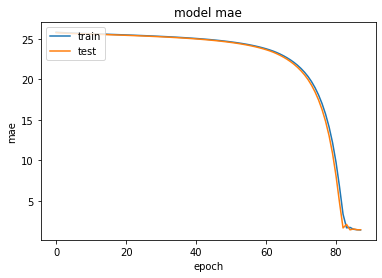

In [ ]:
#history of mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

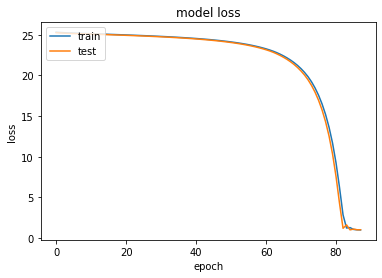

In [ ]:
#history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()